# PCA Autoencoder (Part 2)

In this second part, we will look at a similar dataset of ellipses but with added rotation. The number of latent codes will be increased to 3. The custom layer for computing covariance loss will be adapted to account for three codes. The method used here will deviate from the original paper, since I won't be introducing the hierarchical autoencoders just yet. Instead, I will just rely solely on the covariance loss to make the latent codes distinct from each other. The goal is to have them each capture a single degree of freedom (width, height and rotation).

## Synthesize dataset

In addition to width and heights, the ellipses will be rotated randomly between 0 and $\pi/2$. For that I will just use the `skimage` library.

### Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from skimage.transform import rotate


np.random.seed(42)
tf.random.set_seed(42)

### Phantom binary ellipses

I will use the same image dimension (64, 64) as in Part 1, with a batch size of 500, and a sample size of 8000 to get 16 minibatches per epoch.

In [ ]:
def phantomEllipse(n, a, b, ang):
    x = np.arange(n)
    R = n // 2
    y = x[:, np.newaxis]
    img = (x-R)**2/a**2 + (y-R)**2/b**2
    img[img<=1] = 1
    img[img>1] = 0
    return rotate(img, angle=ang)

I will increase the sample size of dataset, as it produced more consistent results during my test.

In [ ]:
n = 64
num_batch = 32
batch_size = 500
N = int(num_batch * batch_size)
random_gen = np.random.default_rng()
a = random_gen.uniform(1, n//2, N)
b = random_gen.uniform(1, n//2, N)
ang = random_gen.uniform(0, 90, N)
dataset = np.array([phantomEllipse(n, _a, _b, _ang) for _a, _b, _ang in zip(a, b, ang)])
dataset = dataset[..., np.newaxis]

Let's look at a sample of 8 images from the dataset:

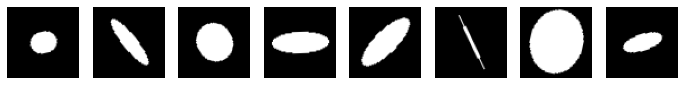

In [ ]:
frames = np.random.choice(np.arange(N), 8)
_, ax = plt.subplots(1, 8, figsize=(12, 3))
for i in range(8):
    ax[i].imshow(dataset[frames[i], ..., 0], cmap=plt.get_cmap('gray'))
    ax[i].axis("off")
plt.show()

## PCA Autoencoder

The PCA autoencoder from Part 1 will be modified to contain 3 latent codes. The covariance loss layer will be adjusted as below.

### Covariance loss

Notice that I opted to "hard code" the covariance term in the custom layer to better demonstrate the process. A general custom layer could be easily written for any given size of the latent space. I will also add a metric to monitor the value of this covariance loss during training.

In [ ]:
class LatentCovarianceLayer(keras.layers.Layer):
    def __init__(self, lam=0.1, **kwargs):
        super().__init__(**kwargs)
        self.lam = lam
    def call(self, inputs):
        code_0 = inputs[:, 0]
        code_1 = inputs[:, 1]
        code_2 = inputs[:, 2]
        covariance = self.lam * tf.math.reduce_mean(tf.math.multiply(code_0, code_1)+
                                                    tf.math.multiply(code_0, code_2)+
                                                    tf.math.multiply(code_1, code_2))
        
        self.add_loss(tf.math.abs(covariance))
        self.add_metric(tf.abs(covariance), name='cov_loss')
        return inputs
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "lam":self.lam,}

I tried different $\lambda$ (the weighting factor) in the covariance loss layer. It seems the standard deviation of the latent codes drops with increasing $\lambda$. Otherwise the results don't seem to be affected by the choice of $\lambda$ that much.

In [ ]:
# SCROLL
encoder = keras.models.Sequential([
    keras.layers.Conv2D(4, (3, 3), padding='same', input_shape=[64, 64, 1]),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(scale=False, center=False),
    keras.layers.Dense(3),
    keras.layers.LeakyReLU(),
    LatentCovarianceLayer(0.6)
])

decoder = keras.models.Sequential([
    keras.layers.Dense(16, input_shape=[3]),
    keras.layers.LeakyReLU(),
    keras.layers.Reshape((2, 2, 4)),
    keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(16, (3, 3),  strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(8, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(4, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same'),
])

keras.backend.clear_session()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
pca_ae = keras.models.Sequential([encoder, decoder])
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_pca_ae.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
32/32 [==============================] - 2s 22ms/step - loss: 0.2087 - cov_loss: 0.0168

Epoch 00001: loss improved from inf to 0.20870, saving model to ./model_pca_ae.hdf5
Epoch 2/1000
32/32 [==============================] - 1s 22ms/step - loss: 0.1651 - cov_loss: 0.0023

Epoch 00002: loss improved from 0.20870 to 0.16515, saving model to ./model_pca_ae.hdf5
Epoch 3/1000
32/32 [==============================] - 1s 22ms/step - loss: 0.1051 - cov_loss: 0.0075

Epoch 00003: loss improved from 0.16515 to 0.10507, saving model to ./model_pca_ae.hdf5
Epoch 4/1000
32/32 [==============================] - 1s 21ms/step - loss: 0.0679 - cov_loss: 0.0033

Epoch 00004: loss improved from 0.10507 to 0.06791, saving model to ./model_pca_ae.hdf5
Epoch 5/1000
32/32 [==============================] - 1s 21ms/step - loss: 0.0591 - cov_loss: 0.0017

Epoch 00005: loss improved from 0.06791 to 0.05909, saving model to ./model_pca_ae.hdf5
Epoch 6/1000
32/32 [==============================] - 

### Check the results

In [ ]:
pca_ae_model = keras.models.load_model('model_pca_ae.hdf5',
                                       custom_objects={"LatentCovarianceLayer": LatentCovarianceLayer})
pca_ae_decoder = pca_ae_model.layers[1]

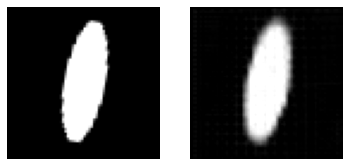

In [ ]:
img = dataset[1430, ...]
img_rec = pca_ae_model.predict(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

The reconstruction quality hasn't significantly improved from using only 2 latent codes. This could however be caused by the relatively shallow decoder.

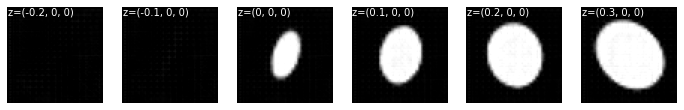

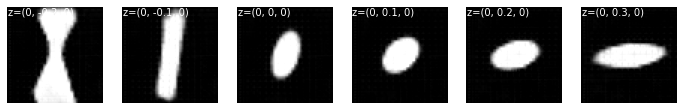

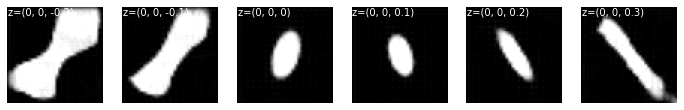

In [ ]:
vals = [-0.2, -0.1, 0, 0.1, 0.2, 0.3,]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[vals[i], 0, 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0, 0)", c='w')
plt.show()


_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[0, vals[i], 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=(0, {vals[i]}, 0)", c='w')
plt.show()


_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[0, 0, vals[i]]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=(0, 0, {vals[i]})", c='w')
plt.show()

One could see a separation of the 3 variables (size, axes, rotation) among the 3 latent codes, as reported by the authors (using the hierarchical method on top of covariance loss). However, it's not as "clean-cut" as demonstrated in Part 1 with only two variables (size and axes). For instance, remnant of rotation can be recognized in the top and middle rows as well.

Finally, we can check how fast the covariance loss term gets minimized relatively to the MSE. 

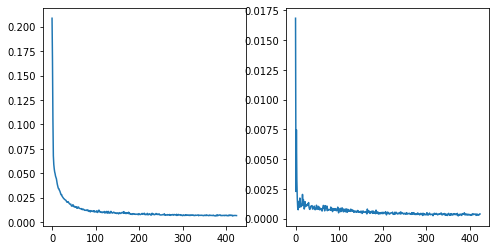

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(history.history['loss'])
ax[1].plot(history.history['cov_loss'])
plt.show()

Interestingly, covariance loss diminishes faster during training. I got a similar result even with $\lambda$ ranging from 0.1 to 10. I wonder if a much deeper autoencoder would further reduce both losses. I may come back to this in the future again.